In [1]:
import numpy as np

In [39]:
import json

contents = []
titles = []

with open('../../signalmedia-1m.jsonl') as newsir_file:
    for line in newsir_file:
        sample = json.loads(line)
        contents.append(sample['content'])
        titles.append(sample['title'])
        
len(contents), len(titles)

(1000000, 1000000)

In [3]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [4]:
# Special tokens
PARAGRAPH_START = '<p>'
PARAGRAPH_END = '</p>'
SENTENCE_START = '<s>'
SENTENCE_END = '</s>'
UNKNOWN_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
DOCUMENT_START = '<d>'
DOCUMENT_END = '</d>'

In [40]:
import nltk, re

def clean_text(text, remove_stopwords=True, max_sentence_count=None):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub('\.{3}', '. ', text)
        
    # Replace '.' with sentence start/end tokens
    if max_sentence_count:
        text = (" ".join(['', SENTENCE_END, SENTENCE_START])).join(text.split('.')[:max_sentence_count])
    else:
        text = (" ".join(['', SENTENCE_END, SENTENCE_START])).join(text.split('.'))
    
    # Add special tokens at both ends of the text
    text = " ".join([DOCUMENT_START, PARAGRAPH_START, SENTENCE_START, text, SENTENCE_END, PARAGRAPH_END, DOCUMENT_END])
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    #text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]]', '', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(nltk.corpus.stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [41]:
from tqdm import tqdm

clean_titles = []
for title in tqdm(titles):
    clean_titles.append(clean_text(title, remove_stopwords=False, max_sentence_count=1))

clean_contents = []
for content in tqdm(contents):
    clean_contents.append(clean_text(content, remove_stopwords=True, max_sentence_count=2))


100%|██████████| 1000000/1000000 [10:50<00:00, 1536.64it/s]


In [44]:
# Inspect the cleaned summaries and texts to ensure they have been cleaned well
for i in range(5):
    print("Article #", i+1)
    print(titles[i], '\n-->\n', clean_titles[i])
    print(contents[i], '\n-->\n', clean_contents[i])
    print()

Article # 1
Worcester breakfast club for veterans gives hunger its marching orders 
-->
 <d> <p> <s> worcester breakfast club for veterans gives hunger its marching orders </s> </p> </d>
VETERANS saluted Worcester's first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. 
 
The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. 
 
The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. 
 
Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. 
 
He said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. 
 
"We even had an old chap travel from Droitwich and he was late on parade by three hours. 
 
"It's generated a lot of interest and I

In [45]:
from sklearn.model_selection import train_test_split

contents = {'full': clean_contents}
titles = {'full': clean_titles}

contents['train'], contents['eval'], titles['train'], titles['eval'] = train_test_split(
    contents['full'], titles['full'], train_size=0.8
)
contents['decode'], contents['eval'], titles['decode'], titles['eval'] = train_test_split(
    contents['eval'], titles['eval'], test_size=0.5
)

In [46]:
from tensorflow.core.example import example_pb2
import struct

for mode in ['train', 'eval', 'decode']:
    with open('data/' + mode + '_newsir', 'wb') as data_file:
        for i in tqdm(range(len(titles[mode]))):
            tf_example = example_pb2.Example()
            tf_example.features.feature['content'].bytes_list.value.extend(
                [contents[mode][i].encode()]
            )
            tf_example.features.feature['title'].bytes_list.value.extend(
                [titles[mode][i].encode()]
            )
            tf_example_str = tf_example.SerializeToString()
            str_len = len(tf_example_str)
            data_file.write(struct.pack('q', str_len))
            data_file.write(struct.pack('%ds' % str_len, tf_example_str))


100%|██████████| 100000/100000 [00:38<00:00, 2598.15it/s]


In [14]:
token_counter = nltk.Counter()

for title in tqdm(clean_titles):
    token_counter.update(title.split())
for content in tqdm(clean_contents):
    token_counter.update(content.split())


100%|██████████| 1000000/1000000 [01:23<00:00, 12018.26it/s]


In [15]:
token_count = sum(token_counter.values())
print(token_count, len(token_counter))

283101801 2400114


In [16]:
vocab_size = 10000

with open('data/vocab_newsir', 'w') as vocab_file:
    most_common_token_count = 0
    for _, num in token_counter.most_common(vocab_size):
        most_common_token_count += num
    print(UNKNOWN_TOKEN, token_count - most_common_token_count, file=vocab_file)
    for token, num in token_counter.most_common(vocab_size):
        print(token, num, file=vocab_file)
    print(PAD_TOKEN, 5, file=vocab_file)
    #for token in [PARAGRAPH_END, PARAGRAPH_START, DOCUMENT_END, DOCUMENT_START]:
    #    print(token, len(processed_df), file=vocab_file)
    #for token in [SENTENCE_END, SENTENCE_START]:
    #    print(token, len(processed_df) + token_counter['.'], file=vocab_file)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

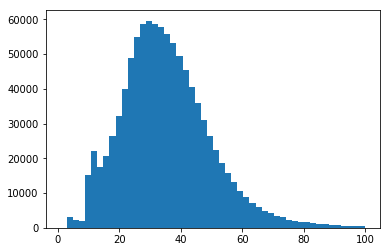

In [50]:
_ = plt.hist([len(content.split()) for content in clean_contents], bins=50, range=(1, 100))

In [51]:
sum([len(content.split()) < 60 for content in clean_contents])

932640

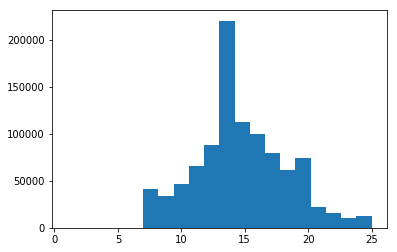

In [49]:
_ = plt.hist([len(title.split()) for title in clean_titles], bins=20, range=(1, 25))

In [55]:
sum([len(title.split()) < 30 for title in clean_titles])

993650